In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler



In [3]:
# Set parameters 

datapath = 'data/'
filename = 'nerdwallet_and_generic'
event_date = pd.to_datetime('2025-02-10') # Super Bowl date is '2025-02-10' so if prior then this is a placebo test
preperiod_length = 90
postperiod_length = 3

start_date = event_date - pd.DateOffset(days=preperiod_length)
end_date = event_date + pd.DateOffset(days=postperiod_length)

In [4]:
# Import data # The data is from Google Trends and contains the search interest for the terms "NerdWallet", "credit card points", "travel credit card", and "best savings account" in the United States.
# Day,NerdWallet: (United States),credit card points: (United States),travel credit card: (United States),best savings account: (United States)
gtrends = pd.read_csv(f'{datapath}{filename}.csv', skiprows=3, names=["date", "nerdwallet", "credit_card_points", "travel_credit_card", "best_savings_account"])
gtrends['date'] = pd.to_datetime(gtrends['date'])
gtrends.head()

,date,nerdwallet,credit_card_points,travel_credit_card,best_savings_account
0,2024-11-01,47,43,42,55
1,2024-11-02,42,45,44,37
2,2024-11-03,41,39,47,29
3,2024-11-04,41,49,45,44
4,2024-11-05,38,42,42,39


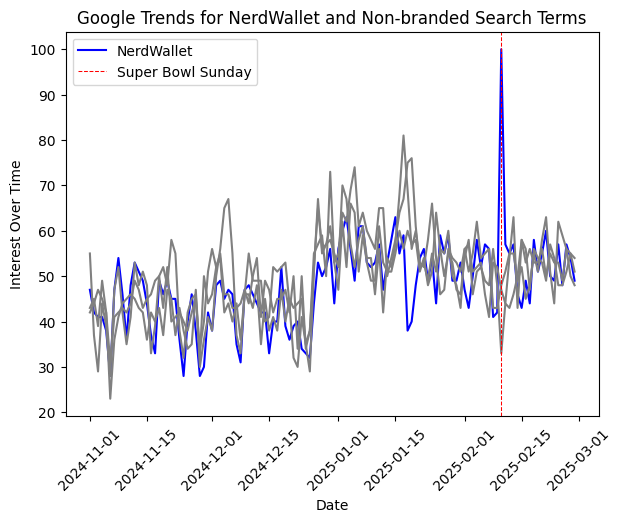

In [5]:
# Plot all search terms

plt.plot(gtrends['date'], gtrends['nerdwallet'], color='blue', label='NerdWallet')
plt.plot(gtrends['date'], gtrends['credit_card_points'], color='gray', label=None)
plt.plot(gtrends['date'], gtrends['travel_credit_card'], color='gray', label=None)
plt.plot(gtrends['date'], gtrends['best_savings_account'], color='gray', label=None)
plt.title('Google Trends for NerdWallet and Non-branded Search Terms')
plt.xlabel('Date')
plt.ylabel('Interest Over Time')
plt.axvline(pd.Timestamp('2025-02-10'), color='red', linestyle='--', label='Super Bowl Sunday', lw=0.75)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [6]:
# TRANSFORM TO PANEL DATA FOR ITS AND DIFFERENCE IN DIFFERENCES

panel = gtrends.melt(id_vars=['date'], 
                                var_name='term', 
                                value_name='search_interest')
print(panel[panel['date'] < event_date].groupby('term')['search_interest'].agg(['mean', 'std']))

                           mean        std
term                                      
best_savings_account  49.673267  10.271425
credit_card_points    47.554455   8.122161
nerdwallet            46.445545   8.489376
travel_credit_card    50.316832   9.257355


#### Interrupted Time Series

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     22.63
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           5.60e-11
Time:                        14:35:21   Log-Likelihood:                -320.51
No. Observations:                  93   AIC:                             649.0
Df Residuals:                      89   BIC:                             659.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.9338      1.650     32.679      0.0

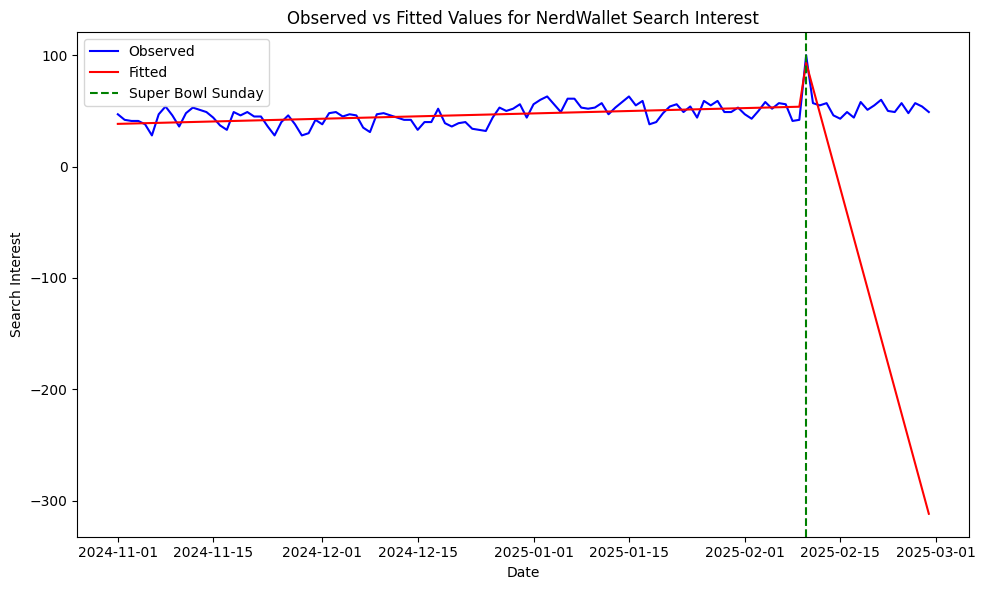

In [7]:
nw = panel[panel['term'] == 'nerdwallet'].copy()
nw['trend'] = (nw['date'] - event_date).dt.days
nw['post'] = (nw['date'] >= event_date).astype(int)
nw['post_trend'] = nw['post'] * nw['trend']

subset = nw[(nw['date'] >= start_date) & (nw['date'] < end_date)].copy()

formula = 'search_interest ~ post + trend + post_trend'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

# Generate predictions for the entire dataset (both in-sample and out-of-sample)
nw['fitted'] = model.predict(nw[['post', 'trend', 'post_trend']])

# Plotting the fitted values for the entire dataset
plt.figure(figsize=(10, 6))
plt.plot(nw['date'], nw['search_interest'], label='Observed', color='blue')
plt.plot(nw['date'], nw['fitted'], label='Fitted', color='red')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Observed vs Fitted Values for NerdWallet Search Interest')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()

#### Implement initial difference-in-differences model

In [8]:
# Test for parallel trends
preperiod = panel[(panel['date'] < event_date) & (panel['date'] >= start_date)].copy()
preperiod['trend'] = (preperiod['date'] - event_date).dt.days
preperiod['treated'] = (preperiod['term'] == 'nerdwallet').astype(int)
preperiod['treated_trend'] = preperiod['treated'] * preperiod['trend']

formula = 'search_interest ~ treated + trend + treated_trend'
model = smf.ols(formula, data=preperiod).fit()
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     35.97
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           2.50e-20
Time:                        14:35:21   Log-Likelihood:                -1257.5
No. Observations:                 360   AIC:                             2523.
Df Residuals:                     356   BIC:                             2539.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        57.4987      0.982     58.544

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     8.515
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           1.76e-05
Time:                        14:35:21   Log-Likelihood:                -1348.4
No. Observations:                 372   AIC:                             2705.
Df Residuals:                     368   BIC:                             2721.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       50.1370      0.555     90.258   

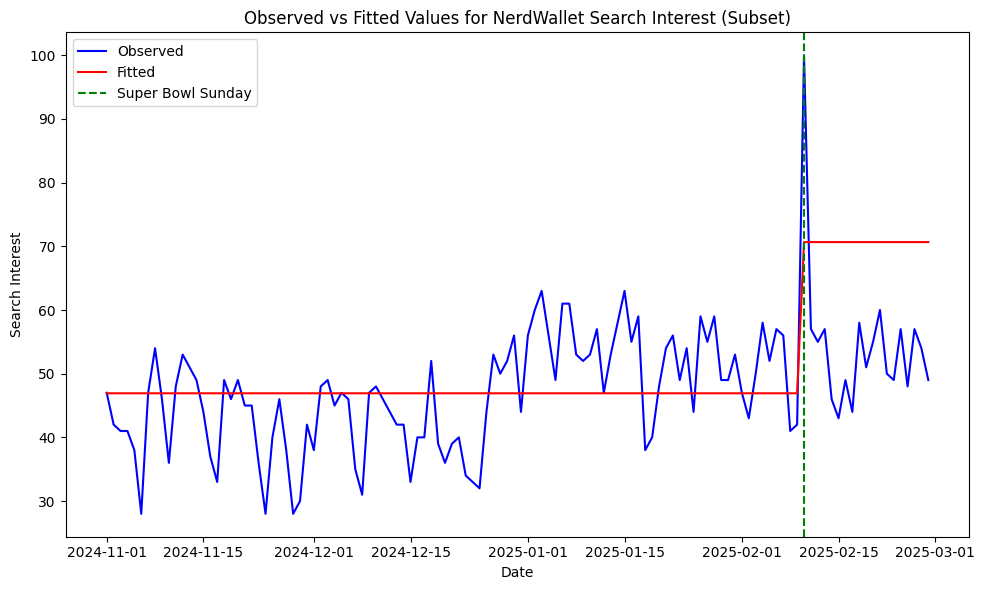

In [9]:
panel['post'] = np.where(panel['date'] >= event_date, 1, 0)
panel['treated'] = np.where(panel['term'] == 'nerdwallet', 1, 0)
panel['post_treated'] = panel['post'] * panel['treated']

subset = panel[(panel['date'] >= start_date) & (panel['date'] < end_date)].copy()

formula = 'search_interest ~ post + treated + post_treated'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

# Plotting the fitted values for the subset: only include for treated group
subset['fitted'] = model.fittedvalues
subset = subset[subset['treated'] == 1].copy()

tmp = panel[panel['treated']==1].copy() 
tmp['fitted'] = model.predict(tmp[['post', 'treated', 'post_treated']])

plt.figure(figsize=(10, 6))
plt.plot(tmp['date'], tmp['search_interest'], label='Observed', color='blue')
plt.plot(tmp['date'], tmp['fitted'], label='Fitted', color='red')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Observed vs Fitted Values for NerdWallet Search Interest (Subset)')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()


#### Diff-in-Diff but with TWFE

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     6.809
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           3.34e-36
Time:                        14:35:22   Log-Likelihood:                -1134.6
No. Observations:                 372   AIC:                             2463.
Df Residuals:                     275   BIC:                             2843.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

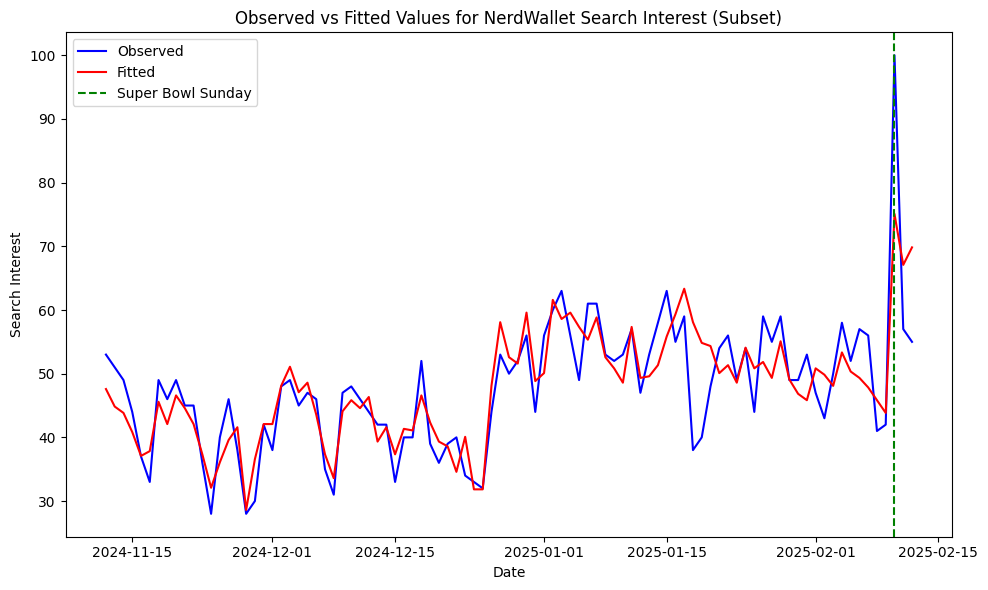

In [10]:
subset = panel[(panel['date'] >= start_date) & (panel['date'] < end_date)].copy()

formula = 'search_interest ~ C(date) + C(term) + post_treated - 1'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

# Plotting the fitted values for the subset: only include for treated group
subset = subset[subset['treated'] == 1].copy()
subset['fitted'] = model.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(subset['date'], subset['search_interest'], label='Observed', color='blue')
plt.plot(subset['date'], subset['fitted'], label='Fitted', color='red')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Observed vs Fitted Values for NerdWallet Search Interest (Subset)')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                 1.591e+12
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           8.10e-19
Time:                        14:35:22   Log-Likelihood:                -1144.7
No. Observations:                 372   AIC:                             2479.
Df Residuals:                     277   BIC:                             2852.
Df Model:                          94                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

/Users/jonathan/Desktop/projects/dividends/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/jonathan/Desktop/projects/dividends/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/jonathan/Desktop/projects/dividends/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/jonathan/Desktop/projects/dividends/venv/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 94, but rank is 4
  warnings.warn('covariance of constraints does not have full '


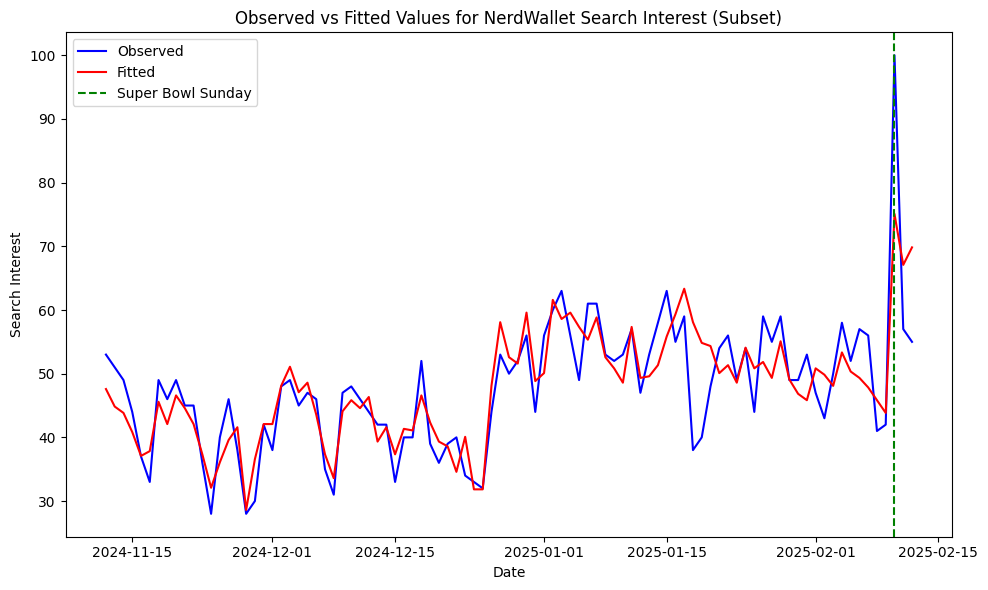

In [11]:
subset = panel[(panel['date'] >= start_date) & (panel['date'] < end_date)].copy()

formula = 'search_interest ~ C(date) + treated + post_treated'
model = smf.ols(formula, data=subset).fit(cov_type='cluster', cov_kwds={'groups': subset['term']})
print(model.summary())

# Plotting the fitted values for the subset: only include for treated group
subset = subset[subset['treated'] == 1].copy()
subset['fitted'] = model.fittedvalues

plt.figure(figsize=(10, 6))
plt.plot(subset['date'], subset['search_interest'], label='Observed', color='blue')
plt.plot(subset['date'], subset['fitted'], label='Fitted', color='red')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Observed vs Fitted Values for NerdWallet Search Interest (Subset)')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()


#### Implement Event Study

In [12]:
subset = gtrends[(gtrends['date'] >= start_date) & (gtrends['date'] < end_date)].copy()
subset['post'] = np.where(subset['date'] >= event_date, 1, 0)

formula = 'nerdwallet ~ post + credit_card_points + travel_credit_card + best_savings_account'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     23.55
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           2.94e-13
Time:                        14:35:22   Log-Likelihood:                -313.03
No. Observations:                  93   AIC:                             636.1
Df Residuals:                      88   BIC:                             648.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.4877 

In [13]:
# Event study to measure declining effects over time 

subset = gtrends[(gtrends['date'] >= start_date) & (gtrends['date'] < end_date)].copy()
subset['trend'] = (subset['date'] - event_date).dt.days
subset['post0'] = np.where(subset['trend'] == 0, 1, 0)
subset['post1'] = np.where(subset['trend'] == 1, 1, 0)
subset['post2'] = np.where(subset['trend'] == 2, 1, 0)

# Also test for days just before the event 
subset['pre1'] = np.where(subset['trend'] == -1, 1, 0)
subset['pre2'] = np.where(subset['trend'] == -2, 1, 0)

formula = 'nerdwallet ~ post0 + post1 + post2 + pre1 + pre2 + credit_card_points + travel_credit_card + best_savings_account'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     23.04
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           3.12e-18
Time:                        14:35:22   Log-Likelihood:                -292.87
No. Observations:                  93   AIC:                             603.7
Df Residuals:                      84   BIC:                             626.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.1037 

#### Implement a synthetic control using lasso regression

Lasso Weights: [1.99428699 0.         4.79176863]


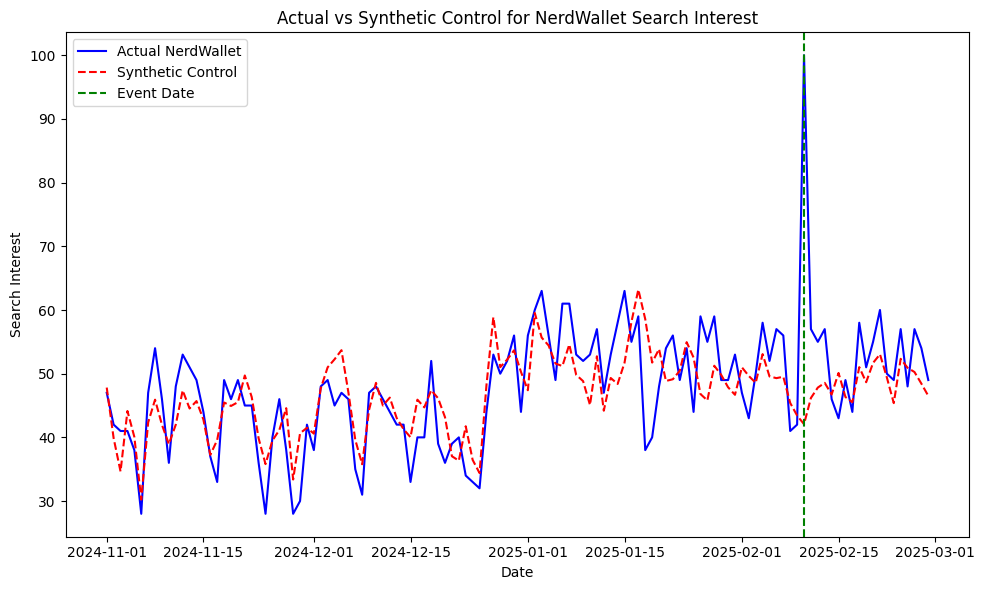

In [14]:
# Filter pre-event_date data
pre_event_data = gtrends[gtrends['date'] < event_date]

# Define predictors (X) and target (y)
X_pre = pre_event_data[['credit_card_points', 'travel_credit_card', 'best_savings_account']]
y_pre = pre_event_data['nerdwallet']

# Standardize the predictors
scaler = StandardScaler()
X_pre_scaled = scaler.fit_transform(X_pre)

# Fit Lasso regression
lasso = Lasso(alpha=0.1)  # You can tune alpha for regularization strength
lasso.fit(X_pre_scaled, y_pre)


# Get weights from Lasso
weights = lasso.coef_
print("Lasso Weights:", weights)

# Use the weights to predict nerdwallet values for the entire period
X_all = gtrends[['credit_card_points', 'travel_credit_card', 'best_savings_account']]
X_all_scaled = scaler.transform(X_all)
gtrends['synthetic_nerdwallet'] = lasso.predict(X_all_scaled)

# Plot actual vs synthetic control values
plt.figure(figsize=(10, 6))
plt.plot(gtrends['date'], gtrends['nerdwallet'], label='Actual NerdWallet', color='blue')
plt.plot(gtrends['date'], gtrends['synthetic_nerdwallet'], label='Synthetic Control', color='red', linestyle='--')
plt.axvline(event_date, color='green', linestyle='--', label='Event Date')
plt.title('Actual vs Synthetic Control for NerdWallet Search Interest')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()



                           mean       std
term                                     
nerdwallet            46.445545  8.489376
synthetic_nerdwallet  46.445545  6.214510
                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     4.389
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           6.02e-12
Time:                        14:35:22   Log-Likelihood:                -497.68
No. Observations:                 186   AIC:                             1185.
Df Residuals:                      91   BIC:                             1492.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                          

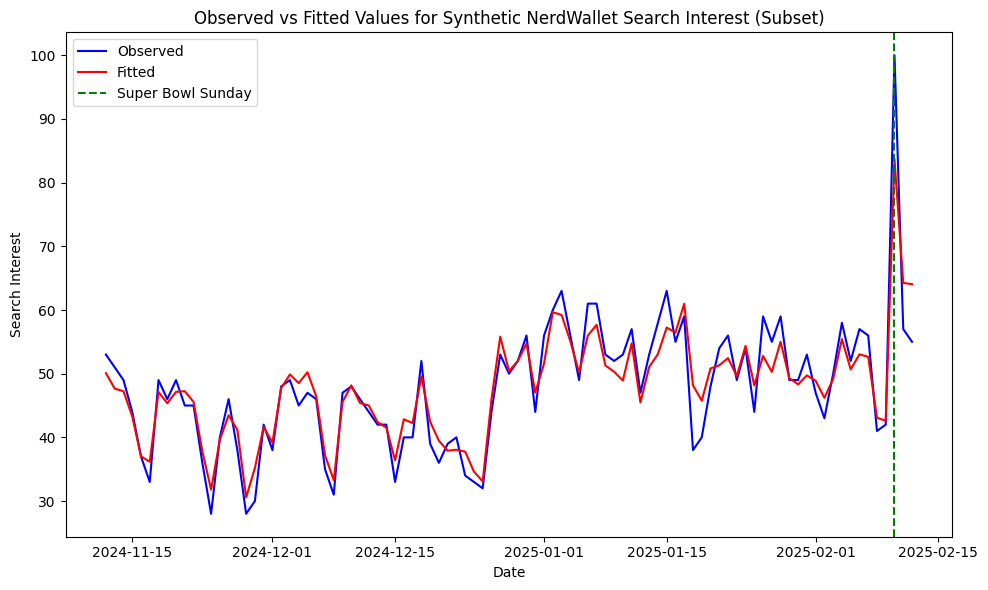

In [15]:
# Estimate a Difference-in-Differences (DiD) model against synthetic control

synth_panel = gtrends[['date','nerdwallet','synthetic_nerdwallet']].melt(id_vars=['date'], 
                                var_name='term', 
                                value_name='search_interest')
print(synth_panel[synth_panel['date'] < event_date].groupby('term')['search_interest'].agg(['mean', 'std']))

synth_panel['post'] = np.where(synth_panel['date'] >= event_date, 1, 0)
synth_panel['treated'] = np.where(synth_panel['term'] == 'nerdwallet', 1, 0)
synth_panel['post_treated'] = synth_panel['post'] * synth_panel['treated']

subset = synth_panel[(synth_panel['date'] >= start_date) & (synth_panel['date'] < end_date)].copy()
formula = 'search_interest ~ C(date) + C(term) + post_treated - 1'
model = smf.ols(formula, data=subset).fit()
print(model.summary())


# Plotting the fitted values for the subset: only include for treated group
subset['fitted'] = model.fittedvalues
subset = subset[subset['treated'] == 1].copy()
plt.figure(figsize=(10, 6))
plt.plot(subset['date'], subset['search_interest'], label='Observed', color='blue')
plt.plot(subset['date'], subset['fitted'], label='Fitted', color='red')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Observed vs Fitted Values for Synthetic NerdWallet Search Interest (Subset)')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()

Optimal alpha: 0.29470517025518095
Lasso Weights: [1.87195513 0.         4.66938813]


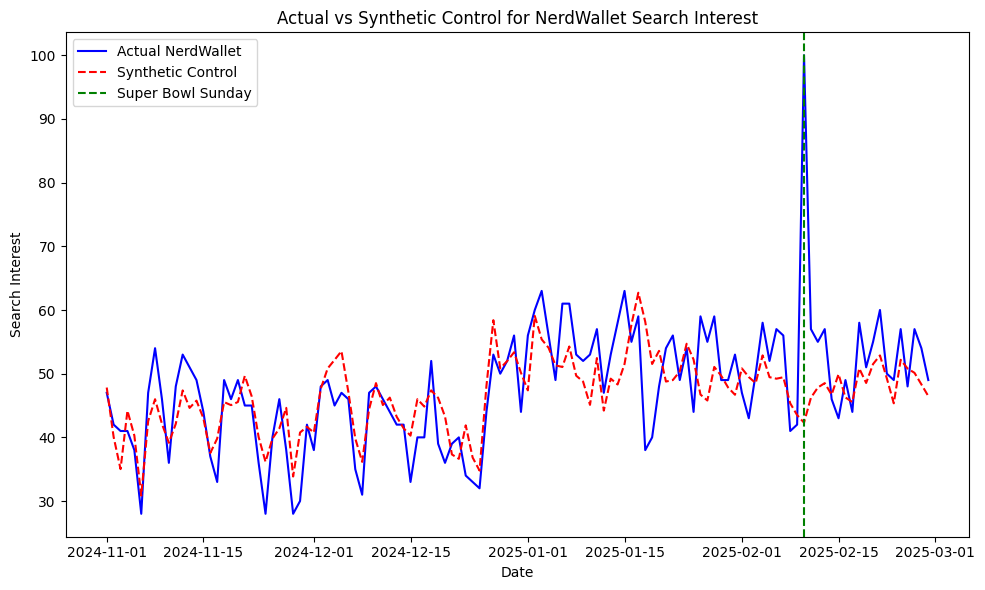

In [16]:
from sklearn.model_selection import GridSearchCV

# Filter pre-event_date data
pre_event_data = gtrends[gtrends['date'] < event_date]

# Define predictors (X) and target (y)
X_pre = pre_event_data[['credit_card_points', 'travel_credit_card', 'best_savings_account']]
y_pre = pre_event_data['nerdwallet']

# Standardize the predictors
scaler = StandardScaler()
X_pre_scaled = scaler.fit_transform(X_pre)

# Define the parameter grid for alpha
param_grid = {'alpha': np.logspace(-4, 1, 50)}

# Use GridSearchCV to find the optimal alpha
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_pre_scaled, y_pre)

# Update the Lasso model with the best alpha
lasso = Lasso(alpha=lasso_cv.best_params_['alpha'])
lasso.fit(X_pre_scaled, y_pre)

print("Optimal alpha:", lasso_cv.best_params_['alpha'])

# Get weights from Lasso
weights = lasso.coef_
print("Lasso Weights:", weights)

# Use the weights to predict nerdwallet values for the entire period
X_all = gtrends[['credit_card_points', 'travel_credit_card', 'best_savings_account']]
X_all_scaled = scaler.transform(X_all)
gtrends['synthetic_nerdwallet'] = lasso.predict(X_all_scaled)

# Plot actual vs synthetic control values
plt.figure(figsize=(10, 6))
plt.plot(gtrends['date'], gtrends['nerdwallet'], label='Actual NerdWallet', color='blue')
plt.plot(gtrends['date'], gtrends['synthetic_nerdwallet'], label='Synthetic Control', color='red', linestyle='--')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Actual vs Synthetic Control for NerdWallet Search Interest')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()




#### DiD is great, but make sure we also do permutation tests for SCs as well

                           mean       std
term                                     
nerdwallet            46.445545  8.489376
synthetic_nerdwallet  46.445545  5.999946
                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     4.295
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           1.13e-11
Time:                        14:35:22   Log-Likelihood:                -497.72
No. Observations:                 186   AIC:                             1185.
Df Residuals:                      91   BIC:                             1492.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                          

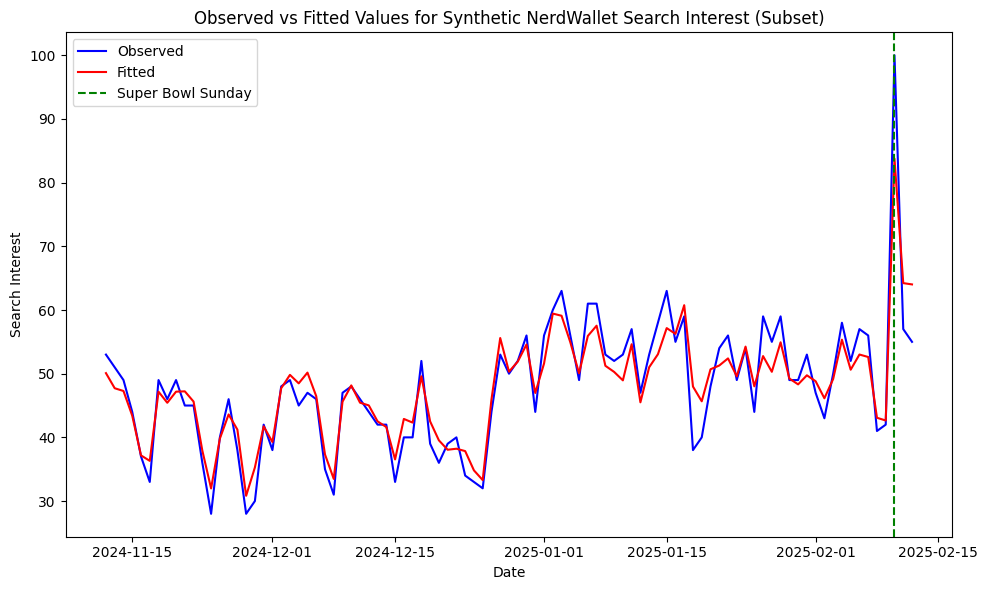

In [17]:
# Estimate a Difference-in-Differences (DiD) model against synthetic control

synth_panel = gtrends[['date','nerdwallet','synthetic_nerdwallet']].melt(id_vars=['date'], 
                                var_name='term', 
                                value_name='search_interest')
print(synth_panel[synth_panel['date'] < event_date].groupby('term')['search_interest'].agg(['mean', 'std']))

synth_panel['post'] = np.where(synth_panel['date'] >= event_date, 1, 0)
synth_panel['treated'] = np.where(synth_panel['term'] == 'nerdwallet', 1, 0)
synth_panel['post_treated'] = synth_panel['post'] * synth_panel['treated']

subset = synth_panel[(synth_panel['date'] >= start_date) & (synth_panel['date'] < end_date)].copy()
formula = 'search_interest ~ C(date) + C(term) + post_treated - 1'
model = smf.ols(formula, data=subset).fit()
print(model.summary())


# Plotting the fitted values for the subset: only include for treated group
subset['fitted'] = model.fittedvalues
subset = subset[subset['treated'] == 1].copy()
plt.figure(figsize=(10, 6))
plt.plot(subset['date'], subset['search_interest'], label='Observed', color='blue')
plt.plot(subset['date'], subset['fitted'], label='Fitted', color='red')
plt.axvline(event_date, color='green', linestyle='--', label='Super Bowl Sunday')
plt.title('Observed vs Fitted Values for Synthetic NerdWallet Search Interest (Subset)')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Define predictors (X) and target (y)
predictors = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

placebo_estimates = []

for i in range(len(predictors)):
    placebo = predictors[i]  # Use the first predictor as placebo for the synthetic control
    placebo_predictors = [predictor for predictor in predictors if predictor != placebo]

    # Filter pre-event_date data
    pre_event_data = gtrends[gtrends['date'] < event_date]

    X_pre = pre_event_data[placebo_predictors]
    y_pre = pre_event_data[placebo]

    # Standardize the predictors
    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)

    # Define the parameter grid for alpha
    param_grid = {'alpha': np.logspace(-4, 1, 50)}

    # Use GridSearchCV to find the optimal alpha
    lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
    lasso_cv.fit(X_pre_scaled, y_pre)

    # Update the Lasso model with the best alpha
    lasso = Lasso(alpha=lasso_cv.best_params_['alpha'])
    lasso.fit(X_pre_scaled, y_pre)


    # Get weights from Lasso
    weights = lasso.coef_
 
    # Use the weights to predict placebo values for the entire period
    X_all = gtrends[placebo_predictors]
    X_all_scaled = scaler.transform(X_all)
    gtrends['synthetic_placebo'] = lasso.predict(X_all_scaled)


    # Estimate a Difference-in-Differences (DiD) model against synthetic control

    synth_panel = gtrends[['date',placebo,'synthetic_placebo']].melt(id_vars=['date'], 
                                    var_name='term', 
                                    value_name='search_interest')
 
    synth_panel['post'] = np.where(synth_panel['date'] >= event_date, 1, 0)
    synth_panel['treated'] = np.where(synth_panel['term'] == placebo, 1, 0)
    synth_panel['post_treated'] = synth_panel['post'] * synth_panel['treated']

    subset = synth_panel[(synth_panel['date'] >= start_date) & (synth_panel['date'] < end_date)].copy()
    formula = 'search_interest ~ C(date) + C(term) + post_treated - 1'
    model = smf.ols(formula, data=subset).fit()

    placebo_estimates.append(model.params['post_treated'])
    print(f"Placebo Variable: {placebo}")
    print(model.params['post_treated'], model.bse['post_treated'], model.pvalues['post_treated'], '\n')

placebo_estimates = pd.Series(placebo_estimates)
print(f"Confidence Interval: ({placebo_estimates.mean() - 1.96 * placebo_estimates.std():.2f}, {placebo_estimates.mean() + 1.96 * placebo_estimates.std():.2f})")


Placebo Variable: credit_card_points
-6.612876303228207 2.688510182103197 0.015795623081079617 

Placebo Variable: travel_credit_card
3.9003649355113783 3.1380371861192473 0.21708615436343245 

Placebo Variable: best_savings_account
5.2817431431365165 4.681289165378823 0.26217310466993926 

Confidence Interval: (-11.89, 13.61)
